In [2]:
from setup_notebook import setup_project_path
setup_project_path()

In [3]:
from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR

In [4]:
import subprocess
import sys
import numpy as np
import os
import pandas as pd
import datetime as dt
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
# import seaborn as sns
import boto3
import time
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from io import BytesIO

In [5]:
data_dir = PROCESSED_DATA_DIR
model_dir = MODELS_DIR

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [6]:
df_train = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_train_days.csv'))
df_test = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_test_days.csv'))
df_oot_validation = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_oot_validation_days.csv'))

df_train = df_train[df_train.backtesting>=360]
df_test = df_test[df_test.backtesting>=360]
df_oot_validation = df_oot_validation[df_oot_validation.backtesting>=360]

In [14]:
df_test[df_test['accounts_group']=='2022-02_Kenya_SHS Entry-Level_Kibwezi_Sun King Home 60 EasyBuy'].T

""
accounts_group
count_units
avg_planned_repayment_days
frr_3_years
actual_fr
total_follow_on_revenue_usd
reg_month
country
product_group
area


In [28]:
df_oot_validation

,accounts_group,count_units,avg_planned_repayment_days,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,...,backtesting,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,avg_upfront_price_usd,avg_unlock_price_usd
1,2022-06_Kenya_Lanterns_Olkalau_Sun King Pro Ea...,4,368,0.935388,174.600736,186.661296,2022-06,Kenya,Lanterns,Olkalau,...,540,0.880822,0.8808,142.0,0.000000,0.000000,0.750000,0.000000,3.0,50.0
2,2022-04_Kenya_SHS Entry-Level_Mandera_Sun King...,131,365,0.854693,21057.981777,24638.065103,2022-04,Kenya,SHS Entry-Level,Mandera,...,630,0.780187,0.7801,218.0,0.032787,0.183206,0.519084,0.366412,14.0,202.0
8,2022-05_Tanzania_SHS with TV Upgrade_Tanga_Sun...,1,598,0.282593,202.465831,716.457348,2022-05,Tanzania,SHS with TV Upgrade,Tanga,...,630,0.282593,0.2825,291.0,0.000000,1.000000,0.000000,1.000000,15.0,732.0
10,2022-04_Kenya_Phones_Garsen_Samsung A03 Core,64,367,0.944940,10485.469288,11096.439232,2022-04,Kenya,Phones,Garsen,...,540,0.854328,0.8543,157.0,0.000000,0.093750,0.484375,0.296875,26.0,199.0
11,2022-03_Kenya_SHS with TV Upgrade_Luanda_Sun K...,7,637,0.859382,3171.226057,3690.123900,2022-03,Kenya,SHS with TV Upgrade,Luanda,...,540,0.608830,0.7196,157.0,0.000000,0.000000,0.000000,0.428571,11.0,538.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201498,2022-05_Uganda_SHS Entry-Level_Tororo_Sun King...,11,402,0.672670,1272.367236,1891.517737,2022-05,Uganda,SHS Entry-Level,Tororo,...,720,0.664102,0.6641,139.0,0.166667,0.545455,0.454545,0.545455,8.0,180.0
201499,2022-06_Kenya_SHS Entry-Level_Olkalau_Sun King...,16,368,0.858211,1708.744307,1991.053840,2022-06,Kenya,SHS Entry-Level,Olkalau,...,720,0.825385,0.8253,119.0,0.000000,0.000000,0.750000,0.062500,13.0,137.0
201501,2022-07_Tanzania_Phones_Mlandizi_Infinix Hot 12i,92,367,0.839934,19905.275713,23698.618836,2022-07,Tanzania,Phones,Mlandizi,...,630,0.821502,0.8215,120.0,0.000000,0.271739,0.608696,0.304348,24.0,281.0
201503,2022-07_Kenya_SHS without TV_Molo_Sun King Hom...,1,465,1.000000,234.236460,234.236460,2022-07,Kenya,SHS without TV,Molo,...,540,0.827020,0.8270,155.0,0.000000,0.000000,0.000000,0.000000,17.0,251.0


In [29]:
df_train[df_train['accounts_group']=='2020-07_Kenya_Lanterns_Kakamega_Sun King Pro EasyBuy']

,accounts_group,count_units,avg_planned_repayment_days,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,...,backtesting,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,avg_upfront_price_usd,avg_unlock_price_usd
57170,2020-07_Kenya_Lanterns_Kakamega_Sun King Pro E...,86,280,0.945901,3104.258218,3281.800334,2020-07,Kenya,Lanterns,Kakamega,...,450,0.831547,0.8315,120.0,0.054054,0.104651,0.569767,0.244186,4.0,42.0
188813,2020-07_Kenya_Lanterns_Kakamega_Sun King Pro E...,86,280,0.945901,3104.258218,3281.800334,2020-07,Kenya,Lanterns,Kakamega,...,630,0.904379,0.9043,150.0,0.111111,0.116279,0.790698,0.162791,4.0,42.0
290622,2020-07_Kenya_Lanterns_Kakamega_Sun King Pro E...,86,280,0.945901,3104.258218,3281.800334,2020-07,Kenya,Lanterns,Kakamega,...,720,0.917469,0.9174,160.0,0.166667,0.058140,0.825581,0.104651,4.0,42.0
438982,2020-07_Kenya_Lanterns_Kakamega_Sun King Pro E...,86,280,0.945901,3104.258218,3281.800334,2020-07,Kenya,Lanterns,Kakamega,...,360,0.760590,0.7605,94.0,0.037037,0.116279,0.372093,0.372093,4.0,42.0


In [30]:
df_oot_validation.shape

(100755, 21)

In [31]:
df_train.shape

(254657, 21)

In [32]:
df_test.shape

(44918, 21)

In [33]:
df_train.columns

Index(['accounts_group', 'count_units', 'avg_planned_repayment_days',
       'frr_3_years', 'actual_fr', 'total_follow_on_revenue_usd', 'reg_month',
       'country', 'product_group', 'area', 'primary_product', 'backtesting',
       'frr', 'repayment_speed', 'avg_cum_days_disabled', 'at_risk_rate',
       'disabled_gt_two_week_rate', 'unlocked_rate', 'disabled_rate',
       'avg_upfront_price_usd', 'avg_unlock_price_usd'],
      dtype='object')

In [34]:
X_train = df_train.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','actual_fr'], axis=1)
y_train = df_train[:]['frr_3_years']

print('shape of the input data: ',X_train.shape)
print('shape of the output data: ',y_train.shape)

X_test = df_test.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','actual_fr'], axis=1)
y_test = df_test[:]['frr_3_years']

print('shape of the input test data: ',X_test.shape)
print('shape of the output test data: ',y_test.shape)

shape of the input data:  (254657, 11)
shape of the output data:  (254657,)
shape of the input test data:  (44918, 11)
shape of the output test data:  (44918,)


In [35]:
# Cross validation
model_lgbm_reg = LGBMRegressor(verbose=-1)
kf =KFold(n_splits=10, shuffle=True, random_state=42)

print('Training and calculating RMSE score on 5 splits of training data......')
score = cross_val_score(model_lgbm_reg, X_train, y_train,  cv= kf, scoring="neg_root_mean_squared_error")
print(f'Scores for each fold: {-score}')
print(f'Mean RMSE score: {np.round(-(score.mean()),4)}')

model_lgbm_reg.fit(X_train, y_train)

Training and calculating RMSE score on 5 splits of training data......
Scores for each fold: [0.05135508 0.05037519 0.04964771 0.05106636 0.05333183 0.05106749
 0.05099717 0.05146484 0.05079104 0.05143069]
Mean RMSE score: 0.0512


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [36]:
X_oot = df_oot_validation.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','actual_fr'], axis=1)
y_oot = df_oot_validation[:]['frr_3_years']

print('shape of the input data: ',X_oot.shape)
print('shape of the output data: ',y_oot.shape)

shape of the input data:  (100755, 11)
shape of the output data:  (100755,)


In [48]:
y_pred_oot = model_lgbm_reg.predict(X_oot)

X_oot_copy = X_oot.copy()
X_oot_copy['actual_frr'] = y_oot
X_oot_copy['predicted_frr'] = y_pred_oot
X_oot_copy['pred_shortfall'] = X_oot_copy['actual_frr'] - X_oot_copy['predicted_frr']

# oot_rmse = np.sqrt(mean_squared_error(y_oot, y_pred_oot))
# print('RMSE score on OOT data: ',oot_rmse)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss
import math, json
results = {
    "rmse": math.sqrt(mean_squared_error(y_oot,y_pred_oot)),
    "mae": mean_absolute_error(y_oot, y_pred_oot),
    "mape": np.mean(np.abs((y_oot - y_pred_oot) / y_oot)),
    "r2": r2_score(y_oot, y_pred_oot),
    "qloss":  mean_pinball_loss(y_oot, y_pred_oot, alpha=0.5)
}

print(json.dumps(results, indent=3))

print('RMSE scores by backtesting limits:')
for backtesting in [360, 450, 540, 630, 720]:
    
    actual_frr = X_oot_copy[X_oot_copy['backtesting']==backtesting]['actual_frr']
    pred_frr = X_oot_copy[X_oot_copy['backtesting']==backtesting]['predicted_frr']
    rmse = np.sqrt(mean_squared_error(actual_frr, pred_frr))
    results = {
        "backtesting": backtesting,
        "rmse": math.sqrt(mean_squared_error(actual_frr,pred_frr)),
        "mae": mean_absolute_error(actual_frr, pred_frr),
        "mape": np.mean(np.abs((actual_frr - pred_frr) / y_oot)),
        "r2": r2_score(actual_frr, pred_frr),
        "qloss":  mean_pinball_loss(actual_frr, pred_frr, alpha=0.5)
    }
    # print('RSME score for backtesting {} is {}'.format(backtesting, rmse))
    print(json.dumps(results, indent=3))

{
   "rmse": 0.054986703138282904,
   "mae": 0.02938838272806942,
   "mape": 0.050099648127699244,
   "r2": 0.8873942252380557,
   "qloss": 0.01469419136403471
}
RMSE scores by backtesting limits:
{
   "backtesting": 360,
   "rmse": 0.0710896381093874,
   "mae": 0.04061838037038398,
   "mape": 0.06877831994461195,
   "r2": 0.811783407223975,
   "qloss": 0.02030919018519199
}
{
   "backtesting": 450,
   "rmse": 0.06274308026504238,
   "mae": 0.034493898087824916,
   "mape": 0.058383838495825804,
   "r2": 0.8533854836315808,
   "qloss": 0.017246949043912458
}
{
   "backtesting": 540,
   "rmse": 0.05322283687928092,
   "mae": 0.028690581658909465,
   "mape": 0.04874861031287894,
   "r2": 0.8945027012805005,
   "qloss": 0.014345290829454732
}
{
   "backtesting": 630,
   "rmse": 0.044583808331135476,
   "mae": 0.02362310702013539,
   "mape": 0.04041747377292416,
   "r2": 0.9259713846280416,
   "qloss": 0.011811553510067695
}
{
   "backtesting": 720,
   "rmse": 0.03615066405521573,
   "mae":

In [38]:
X_oot_copy

,avg_planned_repayment_days,backtesting,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,avg_upfront_price_usd,avg_unlock_price_usd,actual_frr,predicted_frr,pred_shortfall
1,368,540,0.880822,0.8808,142.0,0.000000,0.000000,0.750000,0.000000,3.0,50.0,0.935388,0.958948,-0.023560
2,365,630,0.780187,0.7801,218.0,0.032787,0.183206,0.519084,0.366412,14.0,202.0,0.854693,0.854438,0.000255
8,598,630,0.282593,0.2825,291.0,0.000000,1.000000,0.000000,1.000000,15.0,732.0,0.282593,0.383157,-0.100564
10,367,540,0.854328,0.8543,157.0,0.000000,0.093750,0.484375,0.296875,26.0,199.0,0.944940,0.958346,-0.013406
11,637,540,0.608830,0.7196,157.0,0.000000,0.000000,0.000000,0.428571,11.0,538.0,0.859382,0.897231,-0.037849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201498,402,720,0.664102,0.6641,139.0,0.166667,0.545455,0.454545,0.545455,8.0,180.0,0.672670,0.698329,-0.025659
201499,368,720,0.825385,0.8253,119.0,0.000000,0.000000,0.750000,0.062500,13.0,137.0,0.858211,0.875149,-0.016938
201501,367,630,0.821502,0.8215,120.0,0.000000,0.271739,0.608696,0.304348,24.0,281.0,0.839934,0.866694,-0.026760
201503,465,540,0.827020,0.8270,155.0,0.000000,0.000000,0.000000,0.000000,17.0,251.0,1.000000,0.994773,0.005227


In [39]:
print('Medain shortfall overall: {}'.format(X_oot_copy['pred_shortfall'].median()))
print('Median shortfall by backtesting limits:')
for backtesting in [360, 450, 540, 630, 720]:
    print('Shortfall for backtesting {} is {}'.format(backtesting, X_oot_copy[X_oot_copy['backtesting']==backtesting]['pred_shortfall'].median()))

Medain shortfall overall: -0.00026796694268171883
Median shortfall by backtesting limits:
Shortfall for backtesting 360 is -0.000839603506332498
Shortfall for backtesting 450 is -0.00039654602403893513
Shortfall for backtesting 540 is 9.786694855307143e-05
Shortfall for backtesting 630 is -0.00010998589115129853
Shortfall for backtesting 720 is -0.00035438417912136977


In [40]:
def save_model(model_name, model):
    model_file_name = model_name+"_"+str(date.today()) +".txt"
    model.booster_.save_model(os.path.join(model_dir, model_file_name))

In [41]:
save_model("lgbm_cbr_model", model_lgbm_reg)

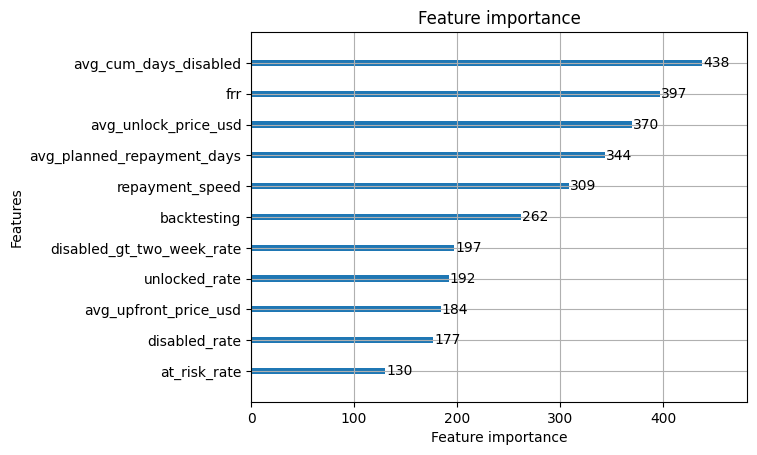

In [42]:
from lightgbm import LGBMRegressor, plot_importance
plot_importance(model_lgbm_reg, max_num_features=20)
plt.show()